## 1. Imports

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## 2. Parkinson Realized Variance

In [21]:
def parkinson_rv(high, low, eps=1e-8):
    rv = (1 / (4 * np.log(2))) * (np.log(high / low) ** 2)
    return np.clip(rv, eps, None)

## 3. USD/INR Data

In [22]:
usd_inr = yf.download(
    "USDINR=X",
    start="2005-01-01",
    auto_adjust=True,
    progress=False)

usd_inr.columns = usd_inr.columns.get_level_values(0)
usd_inr = usd_inr[["High", "Low"]].dropna()

## 4. USD/INR RV + HAR Terms

In [23]:
usd_inr["rv"] = parkinson_rv(usd_inr["High"], usd_inr["Low"])
usd_inr["log_rv"] = np.log(usd_inr["rv"])

usd_inr["log_rv_d"] = usd_inr["log_rv"].shift(1)
usd_inr["log_rv_w"] = usd_inr["log_rv"].rolling(5).mean().shift(1)
usd_inr["log_rv_m"] = usd_inr["log_rv"].rolling(22).mean().shift(1)

usd_inr["vov"] = usd_inr["rv"].rolling(5).std()
usd_inr["log_vov"] = np.log(usd_inr["vov"]).shift(1)

## 5. Exogenous Tickers (ALL with High–Low)

In [24]:
exo_tickers = {
    "DXY": "DX-Y.NYB",
    "BRENT": "BZ=F",
    "VIX": "^VIX",
    "SP500": "^GSPC",
    "NIFTY": "^NSEI"}

exo_raw = yf.download(
    list(exo_tickers.values()),
    start="2005-01-01",
    auto_adjust=True,
    progress=False)

## 6. Parkinson RV for Exogenous Assets

In [25]:
exo_rv = {}

for name, ticker in exo_tickers.items():
    high = exo_raw["High"][ticker]
    low  = exo_raw["Low"][ticker]
    exo_rv[name] = parkinson_rv(high, low)

exo_rv = pd.DataFrame(exo_rv)

## 7. Log-Diff + Lag (Volatility Shocks)

In [26]:
exo_rv = np.log(exo_rv).diff().shift(1)
exo_rv.columns = [f"{c.lower()}_rv" for c in exo_rv.columns]

exo_rv = exo_rv.reindex(usd_inr.index)

## 8. Final Dataset

In [39]:
final_df = (usd_inr[["log_rv", "log_rv_d", "log_rv_w", "log_rv_m", "vov"]])
final_df= final_df.join(exo_rv, how="inner").replace([np.inf, -np.inf], np.nan).dropna()

## Exploratory Data Analysis (EDA)
This section performs Exploratory Data Analysis (EDA) on the dataset used for the HAR-RV-X volatility model.

Important:

No model logic, features, or parameters are changed.
EDA is purely diagnostic and explanatory.
All analysis is based on already constructed variables.
The objective is to:

Understand volatility behavior
Validate linear modeling assumptions
Examine cross-asset and macro spillovers

1. Dataset Overview
We begin by inspecting the structure of the dataset.

Rows represent trading days
Columns include realized volatility measures and exogenous macro/market variables
This confirms there are no missing values or structural issues before modeling.

In [28]:
final_df.head()

,log_rv,log_rv_d,log_rv_w,log_rv_m,vov,dxy_rv,brent_rv,vix_rv,sp500_rv,nifty_rv
Date,,,,,,,,,,
2007-09-19,-10.503172,-10.081385,-11.299698,-10.926156,0.000015,2.142644,0.548331,3.344205,2.468773,0.118452
2007-09-20,-10.035141,-10.503172,-11.120353,-10.977682,0.000017,-1.236175,-1.213265,-2.593212,-1.687686,1.921092
2007-09-21,-10.772474,-10.035141,-10.782049,-10.910220,0.000015,1.751535,0.538860,-0.226535,-0.793019,-3.159473
2007-09-24,-10.201491,-10.772474,-10.614385,-10.884137,0.000010,-1.379579,0.010406,0.363089,-0.096011,2.222900
2007-09-25,-10.191501,-10.201491,-10.318732,-10.848487,0.000009,-0.650576,-0.331076,-0.192108,0.291561,-0.358307


Summary Statistics
Key observations:

Volatility variables are right-skewed
Log-transformed RV stabilizes variance
Exogenous RVs are on different scales (later handled by standardization)

In [29]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
log_rv,3907.0,-11.486133,1.281633,-1.842068e+01,-12.170314,-11.416696,-10.700126,-5.590908
log_rv_d,3907.0,-11.458097,1.317430,-1.842068e+01,-12.141517,-11.376691,-10.667294,-4.848342
log_rv_w,3907.0,-11.475849,1.067851,-1.638493e+01,-11.965636,-11.396187,-10.823585,-8.060208
log_rv_m,3907.0,-11.481439,0.948812,-1.612911e+01,-11.881906,-11.373416,-10.912622,-8.666435
vov,3907.0,0.000025,0.000155,1.003826e-07,0.000004,0.000008,0.000017,0.003496
dxy_rv,3907.0,-0.002878,1.070091,-8.459071e+00,-0.681404,-0.003117,0.650507,9.221039
brent_rv,3907.0,-0.060509,2.029397,-1.352329e+01,-0.795001,-0.064616,0.665396,12.241604
vix_rv,3907.0,-0.004407,1.070782,-4.302471e+00,-0.737497,-0.051445,0.681515,4.537919
sp500_rv,3907.0,-0.005330,1.051651,-3.223371e+00,-0.744298,-0.019966,0.711854,4.424958
nifty_rv,3907.0,-0.023132,1.031139,-4.897915e+00,-0.733918,-0.060104,0.653751,5.775817


Distribution of Realized Volatility
Realized volatility typically exhibits:

Heavy tails
Positive skewness
Volatility clustering
This justifies the log-RV transformation used in HAR models.

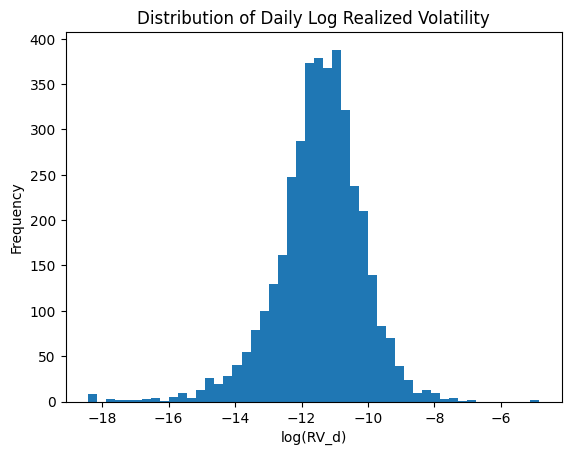

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(final_df['log_rv_d'], bins=50)
plt.title('Distribution of Daily Log Realized Volatility')
plt.xlabel('log(RV_d)')
plt.ylabel('Frequency')
plt.show()

Volatility Clustering (Time Series View)
Volatility clustering implies:

High volatility tends to be followed by high volatility

This property is the core motivation behind HAR-RV models using lagged averages.

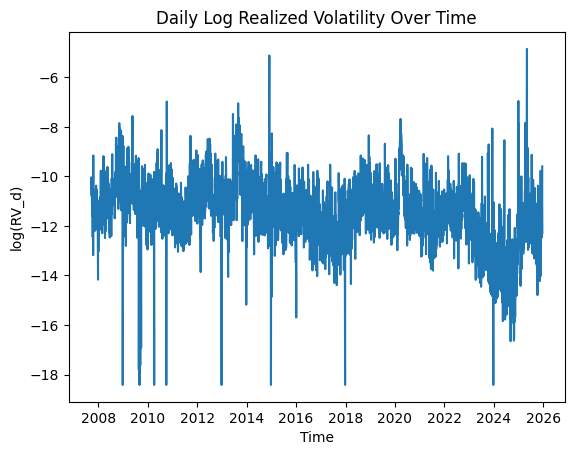

In [31]:
plt.figure()
plt.plot(final_df.index, final_df['log_rv_d'])
plt.title('Daily Log Realized Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('log(RV_d)')
plt.show()

Rolling Volatility Comparison
We visualize the HAR components:

Daily volatility
Weekly average volatility
Monthly average volatility
These capture heterogeneous market participants:

Traders (daily)
Institutions (weekly)
Long-term investors (monthly)

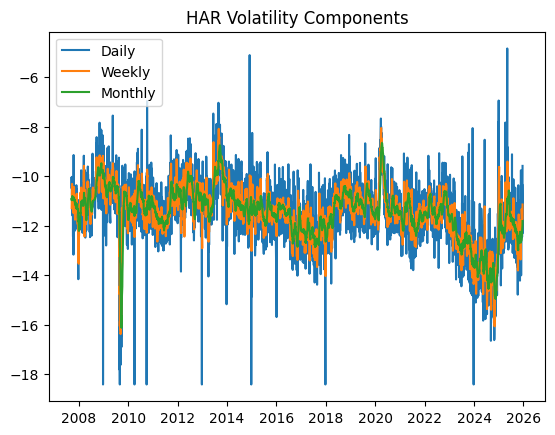

In [41]:
plt.figure()
plt.plot(final_df['log_rv_d'], label='Daily')
plt.plot(final_df['log_rv_w'], label='Weekly')
plt.plot(final_df['log_rv_m'], label='Monthly')
plt.legend()
plt.title('HAR Volatility Components')
plt.show()

Correlation Heatmap
This heatmap shows linear relationships between:

HAR components
Macro volatility proxies
Cross-market spillovers
Strong correlations justify:

Multivariate linear regression
Inclusion of exogenous RV variables (HAR-RV-X)

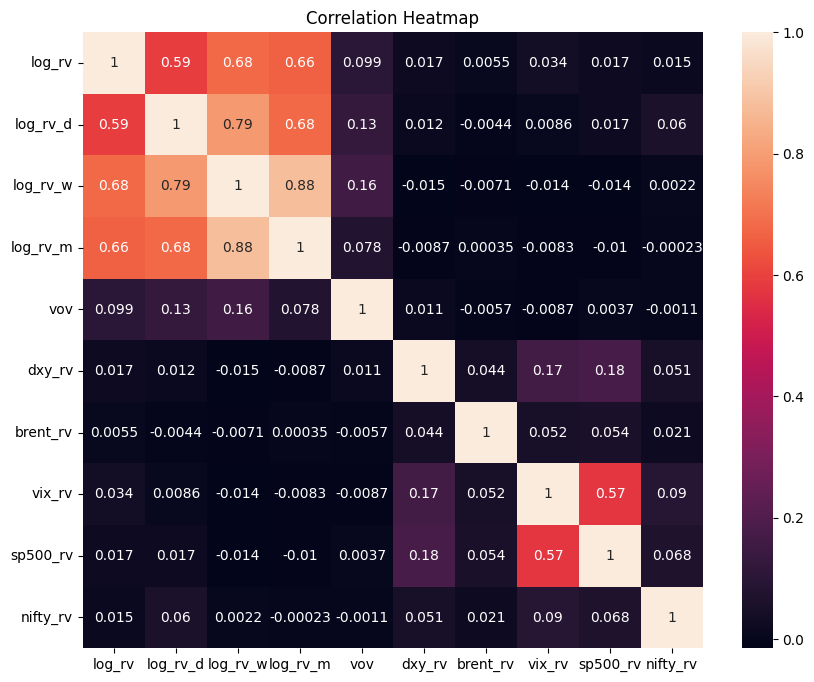

In [33]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(final_df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

Interpretation

- log_rv_w and log_rv_m show strong correlation with future volatility
- VIX and DXY RV show positive spillover effects
- Equity indices have weaker but non-zero influence

This empirically supports the final HAR-RV-X specification.

## 6. Core HAR-RV-X Model Formula (For Reference)

The model estimated later in this notebook follows:

$$
\log(RV_t) = \beta_0 + \beta_d \log(RV_{t-1}) + \beta_w \log(RV_{t-5:t-1}) + \beta_m \log(RV_{t-22:t-1}) + \sum_k \gamma_k X_{k,t} + \varepsilon_t
$$

Where:
- $RV_t$ = Realized volatility at time $t$
- $X_{k,t}$ = Exogenous volatility variables (VIX, DXY, Oil, Equities)
- $\varepsilon_t$ = Error term


## 7. Key EDA Conclusions

- Volatility is persistent and clustered
- Log transformation is essential
- Lagged RV components are strongly informative
- Macro and global market volatility significantly influence USD/INR

**Conclusion:**
The data strongly supports a linear HAR-RV-X framework without requiring non-linear volatility models.

## 8. Train / Test Split

In [34]:
split = int(len(final_df) * 0.8)

train = final_df.iloc[:split]
test  = final_df.iloc[split:]

X_train = train.drop(columns="log_rv")
y_train = train["log_rv"]

X_test  = test.drop(columns="log_rv")
y_test  = test["log_rv"]

## 9. HAR-RV-X Model

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## 10. Evaluation

In [36]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FINAL HAR-RV-X (Parkinson) RESULTS")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")

FINAL HAR-RV-X (Parkinson) RESULTS
R²   : 0.4473
RMSE : 1.0421


## 11. Coefficients (Interpretation)

In [38]:
coef_df = pd.DataFrame(
    {"Variable": X_train.columns,"Coefficient": model.coef_}).sort_values("Coefficient", key=abs, ascending=False)

coef_df

,Variable,Coefficient
3,vov,97.705730
1,log_rv_w,0.384933
2,log_rv_m,0.332353
0,log_rv_d,0.134334
6,vix_rv,0.052329
4,dxy_rv,0.024069
5,brent_rv,0.003378
7,sp500_rv,-0.000538
8,nifty_rv,0.000358
